# Data Prep for CPS: Robotics
Nathan Butler  |  nlbutler@iastate.edu

Following are some instructions for all the theme groups.
1. The final code must be pushed to git before the deadline.
2. Use the discussion board in Canvas in case of any issue.

If the group has technical questions related to the homework, don’t hesitate to get in touch with Ryan (hjy@iastate.edu)

----
In robotics application, we often have to pre-process the input images being used by a robot to improve the learning capabilities of the robot. We will explore a few examples of such pre-processing techniques in this assignment.

We will use the Grasping Dataset available at  https://www.kaggle.com/oneoneliu/cornell-grasp to pre-process images so that a robot arm can learn to detect and grasp an object.

The dataset contains raw images of the objects, coordinates and labels of grasping rectangles as well as point cloud data of the objects. 

# Part 1
Download the dataset and overlay the positive and negative grasping rectangles for each image on the raw image using the coordinates of the rectangles provided.

In [ ]:
# Imports
import os
import urllib.request
import zipfile
import numpy as np

# Toggle download of dataset (only run once, then set to False)
download = True

if download:
    # Download dataset from Kaggle
    url = 'https://www.kaggle.com/oneoneliu/cornell-grasp'
    os.environ['KAGGLE_USERNAME'] = 'nathanbutler001'
    os.environ['KAGGLE_KEY'] = '6fe5bd3a95947b3bfdcfb6f0183217e7'
    !kaggle datasets download -d oneoneliu/cornell-grasp
    with zipfile.ZipFile('cornell-grasp.zip', 'r') as zip_ref:
        zip_ref.extractall()

# Load dataset
dataset_path = './'
image_paths = []
for i in range(1, 11):
    # Define folder path by joining 01 through 10 to dataset_path
    folder_path = os.path.join(dataset_path, f'{i:02d}')
    names = os.listdir(folder_path)
    # Fill list containing all png image filepaths
    for name in names:
        if name.endswith('r.png'):
            image_path = os.path.join(folder_path, name)
            image_paths.append(image_path)

100% 4.85G/4.85G [00:21<00:00, 188MB/s]
100% 4.85G/4.85G [00:21<00:00, 239MB/s]


In [ ]:
import cv2
import matplotlib.pyplot as plt

# Will be populated with images with rectangle overlays
overlayed_images = []

# Overlay images with grasping rectangles
for image_path in image_paths:
    # print(image_path)
    # Load image
    image = cv2.imread(image_path)
    
    # Load positive grasping rectangle
    pos_rect_path = image_path.replace('r.png', 'cpos.txt')
    try:
        pos_rects = np.loadtxt(pos_rect_path)
    except UserWarning:
        pass
    pos_rects = pos_rects.astype(int)
    pos_rects_coords = [[[a[0], a[1]], [b[0], b[1]], [c[0], c[1]], [d[0], d[1]]] 
                        for a, b, c, d in zip(pos_rects[::4], pos_rects[1::4], 
                                              pos_rects[2::4], pos_rects[3::4])]
    pos_rects_coords = np.array(pos_rects_coords, np.int32)
    
    # Load negative grasping rectangles
    neg_rect_path = image_path.replace('r.png', 'cneg.txt')
    try:
        neg_rects = np.loadtxt(neg_rect_path)
    except UserWarning:
        pass
    neg_rects = neg_rects.astype(int)
    neg_rects_coords = [[[a[0], a[1]], [b[0], b[1]], [c[0], c[1]], [d[0], d[1]]] 
                        for a, b, c, d in zip(neg_rects[::4], neg_rects[1::4], 
                                              neg_rects[2::4], neg_rects[3::4])]
    neg_rects_coords = np.array(neg_rects_coords, np.int32)
    
    # Overlay grasping rectangles on image
    image_copy = image.copy()
    for rect in pos_rects_coords:
        cv2.polylines(image_copy, [rect], True, (0, 255, 0), thickness=1)
    for rect in neg_rects_coords:
        cv2.polylines(image_copy, [rect], True, (0, 0, 255), thickness=1)
    
    overlayed_images.append(image_copy)

# UserWarning is probably thrown because pcd0154cneg.txt is empty. This makes me sad, but everything still 
# seems to work.

<ipython-input-9-64f32fe01fc1>:28: UserWarning: loadtxt: Empty input file: "./01/pcd0154cneg.txt"
  neg_rects = np.loadtxt(neg_rect_path)


./10/pcd1001r.png


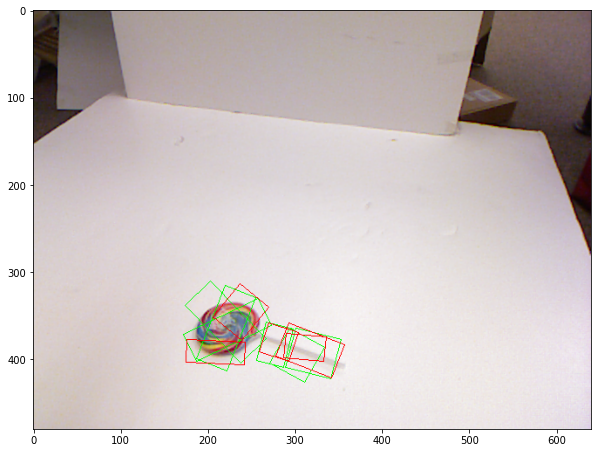

In [ ]:
import random

# To test, display Random image
idx = random.randint(0,len(overlayed_images))

img = overlayed_images[idx]

print(image_paths[idx])    
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# Part 2 
Using the PNG images and point cloud data, register the point cloud data to the PNG images to obtain a 4 channel RGB-D image (Hint: Some details on how to register the point clouds to the image can be found in the README file on the kaggle url link provided above).

In [ ]:
!pip install open3d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.5/422.5 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 84.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 KB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 76.5 MB/s eta 0:00:00
  Attempting uninstall: nbformat
    Found existing installation: nbformat 5.7.3
    Uninstalling nbformat-5.7.3:
      Successfully uninstalled nbformat-5.7.3


In [ ]:
import os
import shutil
# Moving all the images in one folder and renaming them so it matches the pcd file

# Set the paths for the source and destination folders
src_folder = './'
dst_folder = './new_image/'

# Create the destination folder if it doesn't exist
if not os.path.exists(dst_folder):
    os.makedirs(dst_folder)

# Loop through all the folders
for i in range(1, 11):
    # Define folder path by joining 01 through 10 to dataset_path
    folder_path = os.path.join(src_folder, f'{i:02d}')
    
    # Loop through all the png files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith('.png'):
            # Rename the file by removing the 'r' at the end
            new_filename = filename[:-5] + '.png'
            # Set the source and destination paths
            src_path = os.path.join(folder_path, filename)
            dst_path = os.path.join(dst_folder, new_filename)
            # Copy the file to the destination folder
            shutil.copy(src_path, dst_path)


In [ ]:
# Moving all the pcd in one folder 
# Define the old and new folder paths
old_folder_path = './'
new_folder_path = './new_txt/'

# Create the new folder if it doesn't already exist
if not os.path.exists(new_folder_path):
    os.makedirs(new_folder_path)

# Loop over all folders
for folder_num in range(1, 11):
    # Define folder path by joining 01 through 10 to dataset_path
    folder_path = os.path.join(old_folder_path, f'{folder_num:02d}')

    # Get a list of all txt files in the folder
    txt_files = [f for f in os.listdir(folder_path) if f.endswith('.txt')]

    # Loop over all txt files in the folder
    for file_name in txt_files:
        # Define the old file path
        old_file_path = os.path.join(folder_path, file_name)

        # Define the new file name without the folder number
        if '_' in file_name:
            new_file_name = file_name.split('_', 1)[1]
        else:
            new_file_name = file_name

        # Define the new file path
        new_file_path = os.path.join(new_folder_path, new_file_name)

        # Copy the file to the new folder
        with open(old_file_path, 'r') as old_file, open(new_file_path, 'w') as new_file:
            new_file.write(old_file.read())


In [ ]:
# takes likes 25 min to execute
import cv2
import open3d as o3d
import numpy as np
import os

# set path to data
data_path = os.getcwd()

# set path to image folder
image_path = os.path.join(data_path, "new_image")

# set path to PCD folder
pcd_path = os.path.join(data_path, "new_txt")

# create directory to store RGBD images
rgbd_path = os.path.join(data_path, "rgbd")
os.makedirs(rgbd_path, exist_ok=True)

# loop through PNG files in image folder
for png_file in os.listdir(image_path):
    # check if file is a PNG image
    if not png_file.endswith(".png"):
        continue
    
    # get path to PNG file
    png_path = os.path.join(image_path, png_file)
    
    # get prefix of PNG file
    png_prefix = os.path.splitext(png_file)[0]
    
    # check if corresponding PCD file exists
    pcd_file = os.path.join(pcd_path, png_prefix + ".txt")
    if not os.path.exists(pcd_file):
        print(f"No PCD file found for {png_file}")
        continue

    # load PNG image
    image = cv2.imread(png_path)
    
    # load PCD file
    pcd = o3d.io.read_point_cloud(pcd_file, format='xyz')
    if pcd is None:
        print(f"Error loading PCD file {pcd_file}")
        continue
        
    # create depth image from PCD data
    depth_image = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)
    for point in np.asarray(pcd.points):
        x = int(round((point[0] * 525 / point[2]) + 319.5))
        y = int(round((point[1] * 525 / point[2]) + 239.5))
        if (x >= 0 and x < image.shape[1] and y >= 0 and y < image.shape[0]):
            depth_image[y,x] = point[2]
            
    # create RGBD image
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
        o3d.geometry.Image(image),
        o3d.geometry.Image(depth_image),
        convert_rgb_to_intensity=False)

  


    # save RGBD image with a unique identifier in the filename
    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S-%f")
    rgbd_file = os.path.join(rgbd_path, f"{png_prefix}-{timestamp}.npz")
    np.savez(rgbd_file, color=rgbd_image.color, depth=rgbd_image.depth)    


In [ ]:
#Just to check the output
import os
import random
#Check the number of Files
folder_path = "/content/rgbd"
file_list = os.listdir(folder_path)
num_files = len(file_list)

print(f"There are {num_files} files in the folder {folder_path}")

folder_path = '/content/rgbd'

# Get a list of all files in the folder
file_list = os.listdir(folder_path)

# Choose a random file from the list
random_file = random.choice(file_list)

# Load the npz file
data = np.load(os.path.join(folder_path, random_file))

# Access the arrays in the file
color_array = data['color']
depth_array = data['depth']

# Print the shape of the arrays
print('Color array shape:', color_array.shape)
print('Depth array shape:', depth_array.shape)



There are 885 files in the folder /content/rgbd
Color array shape: (480, 640, 3)
Depth array shape: (480, 640)


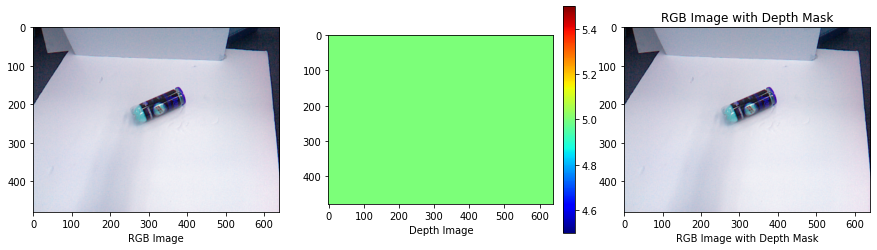

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

# Set the path to the directory containing the npz files
directory_path = 'rgbd/'

# Get a list of all npz files in the directory
data_files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith('.npz')]

# Choose a random npz file from the directory
data_file = random.choice(data_files)

# Load the data from the chosen npz file
data = np.load(data_file)

# Access the RGB and depth images
rgb = data['color']
depth = data['depth']

# Set all depth values to 5 meters
depth[:] = 5.0

# Create a colormap to visualize the distance values
cmap = plt.cm.jet
norm = plt.Normalize(depth.min(), depth.max())

# Plot the RGB and depth images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(rgb)
im = axs[1].imshow(depth, cmap=cmap, norm=norm)
fig.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)

# Expand the depth array to have the same shape as rgb
depth_expanded = np.repeat(depth[:, :, np.newaxis], 3, axis=2)

# Mask the RGB image using the depth image
masked_rgb = np.ma.masked_where(depth_expanded == 60, rgb)

# Plot the masked RGB image
axs[2].imshow(masked_rgb)
axs[2].set_title('RGB Image with Depth Mask')

# Set the x and y labels of the plot
axs[0].set_xlabel('RGB Image')
axs[1].set_xlabel('Depth Image')
axs[2].set_xlabel('RGB Image with Depth Mask')

plt.show()



# Part 3 
Using the RGB-D images above, extract sub-patches of images that are found within the
coordinates of the positive grasping rectangles. Now, we will extract 4 channels worth of
features from these sub-patches. Convert the first 3 channels of the RGB- D image to
YUV color format to get features representing the color and intensity. Next, extract the
last channel of the RGB-D image and convert it to a single image representing the depth
of the features. 

In [ ]:
import datetime
import datetime as dt
from datetime import datetime
import os

directory_path = 'rgbd/'
# function to extract sub-patches
def extract_sub_patches(image, x, y, w, h):
    """
    Extracts sub-patches from an image based on the coordinates of a positive grasping rectangle.
    :param image: The input image.
    :param x: The x-coordinate of the top-left corner of the rectangle.
    :param y: The y-coordinate of the top-left corner of the rectangle.
    :param w: The width of the rectangle.
    :param h: The height of the rectangle.
    :return: A tuple containing the sub-patches of the RGB-D image.
    """
    color_patch = image.color[y:y+h, x:x+w]
    depth_patch = image.depth[y:y+h, x:x+w]
    
    # convert first 3 channels of color_patch to YUV color format
    yuv_patch = cv2.cvtColor(color_patch, cv2.COLOR_BGR2YUV)
    
    return (color_patch, yuv_patch, depth_patch)

# loop through PNG files in image folder
for png_file in os.listdir(directory_path):
    # check if file is a PNG image
    if not png_file.endswith(".png"):
        continue
    
    # get path to PNG file
    png_path = os.path.join(directory_path, png_file)
    
    # get prefix of PNG file
    png_prefix = os.path.splitext(png_file)[0]
    
    # check if corresponding PCD file exists
    pcd_file = os.path.join(pcd_path, png_prefix + ".txt")
    if not os.path.exists(pcd_file):
        print(f"No PCD file found for {png_file}")
        continue
    
    # load PNG image
    image = cv2.imread(png_path)
    
    # load PCD file
    pcd = o3d.io.read_point_cloud(pcd_file, format='xyz')
    if pcd is None:
        print(f"Error loading PCD file {pcd_file}")
        continue
        
    # create depth image from PCD data
    depth_image = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)
    for point in np.asarray(pcd.points):
        x = int(round((point[0] * 525 / point[2]) + 319.5))
        y = int(round((point[1] * 525 / point[2]) + 239.5))
        if (x >= 0 and x < image.shape[1] and y >= 0 and y < image.shape[0]):
            depth_image[y,x] = point[2]
    
    # create RGBD image
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
        o3d.geometry.Image(image),
        o3d.geometry.Image(depth_image),
        convert_rgb_to_intensity=False)
    
    # extract sub-patches from RGBD image based on positive grasping rectangles
    for rect in positive_grasping_rectangles:
        x, y, w, h = rect
        color_patch, yuv_patch, depth_patch = extract_sub_patches(rgbd_image, x, y, w, h)
        
        # perform feature extraction on sub-patches
        # ...
    
    # save RGBD image with a unique identifier in the filename
    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S-%f")
    rgbd_file = os.path.join()

#Part 4
Next, apply PCA Whitening to the depth features extracted above to further reduce any
bias in the depth features. Refer to links below for more information on how to whiten an
image:

• http://ufldl.stanford.edu/tutorial/unsupervised/PCAWhitening/

• http://ufldl.stanford.edu/tutorial/unsupervised/ExercisePCAWhitening/

In [ ]:
import os
import datetime
import datetime as dt
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# loop through PNG files in image folder
for png_file in os.listdir(directory_path):
    # check if file is a PNG image
    if not png_file.endswith(".png"):
        continue
    
    # get path to PNG file
    png_path = os.path.join(directory_path, png_file)
    
    # get prefix of PNG file
    png_prefix = os.path.splitext(png_file)[0]
    
    # check if corresponding PCD file exists
    pcd_file = os.path.join(pcd_path, png_prefix + ".txt")
    if not os.path.exists(pcd_file):
        print(f"No PCD file found for {png_file}")
        continue
    
    # load PNG image
    image = cv2.imread(png_path)
    
    # load PCD file
    pcd = o3d.io.read_point_cloud(pcd_file, format='xyz')
    if pcd is None:
        print(f"Error loading PCD file {pcd_file}")
        continue
        
    # create depth image from PCD data
    depth_image = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)
    for point in np.asarray(pcd.points):
        x = int(round((point[0] * 525 / point[2]) + 319.5))
        y = int(round((point[1] * 525 / point[2]) + 239.5))
        if (x >= 0 and x < image.shape[1] and y >= 0 and y < image.shape[0]):
            depth_image[y,x] = point[2]
    
    # create RGBD image
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
        o3d.geometry.Image(image),
        o3d.geometry.Image(depth_image),
        convert_rgb_to_intensity=False)
    
    # extract sub-patches from RGBD image based on positive grasping rectangles
    for rect in positive_grasping_rectangles:
        x, y, w, h = rect
        color_patch, yuv_patch, depth_patch = extract_sub_patches(rgbd_image, x, y, w, h)
        
        # perform feature extraction on sub-patches
        # ...
    
    # apply PCA whitening to depth features
    depth_features = depth_image.reshape(-1, 1)
    scaler = StandardScaler()
    depth_features_scaled = scaler.fit_transform(depth_features)
    pca = PCA(whiten=True)
    depth_features_whitened = pca.fit_transform(depth_features_scaled)
    depth_image_whitened = depth_features_whitened.reshape(depth_image.shape)
    
    # create RGBD image
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
        o3d.geometry.Image(image),
        o3d.geometry.Image(depth_image_whitened),
        convert_rgb_to_intensity=False)
    
    # save RGBD image with a unique identifier in the filename
    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S-%f")
    rgbd_file = os.path.join(rgbd_path, f"{png_prefix}-{timestamp}.npz")
    np.savez(rgbd_file, color=rgbd_image.color, depth=rgbd_image.depth)

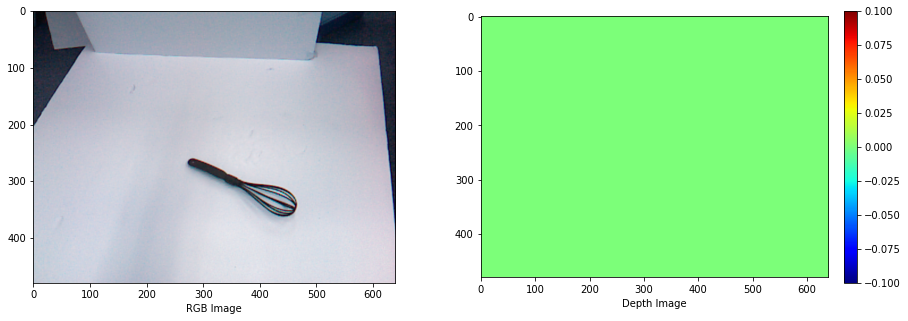

In [ ]:
import random

import os
import numpy as np
import matplotlib.pyplot as plt

# set the path to the directory containing RGBD images
rgbd_path = "rgbd/"

# get a list of all RGBD images in the directory
rgbd_files = [f for f in os.listdir(rgbd_path) if f.endswith(".npz")]

# select a random RGBD image
rgbd_file = np.random.choice(rgbd_files)

# load the RGBD image
rgbd_data = np.load(os.path.join(rgbd_path, rgbd_file))
color_image = rgbd_data["color"]
depth_image = rgbd_data["depth"]


# Create a colormap to visualize the distance values
cmap = plt.cm.jet
norm = plt.Normalize(depth.min(), depth.max())

# Plot the RGB and depth images
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(color_image)
im = axs[1].imshow(depth_image, cmap=cmap, norm=norm)
fig.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)

# Expand the depth array to have the same shape as rgb
depth_expanded = np.repeat(depth[:, :, np.newaxis], 3, axis=2)

axs[0].set_xlabel('RGB Image')
axs[1].set_xlabel('Depth Image')


plt.show()


# Part 5
Visualize the point cloud data using Rviz (by converting the .txt files to .ply files, and then using the ply files create rosbag files to render in Rviz).

In [ ]:
import numpy as np

# Load dataset
dataset_path = os.getcwd()
cloud_paths = []
for i in range(1, 11):
    # Define folder path by joining 01 through 10 to dataset_path
    folder_path = os.path.join(dataset_path, f'{i:02d}')
    names = os.listdir(folder_path)
    # Fill list containing all point cloud txt filepaths
    for name in names:
        if not (name.endswith('r.png') or name.endswith('neg.txt') or name.endswith('pos.txt') or name.endswith('d.tiff') or name.endswith('.ply')):
            cloud_path = os.path.join(folder_path, name)
            cloud_paths.append(cloud_path)

  
# Convert point cloud txt files to ply files
#-------------------------------------------------------------

# File path setup (all ply files will be saved to folder ply_files)
if not os.path.exists('./ply_files'):
  ply_path = os.path.join(dataset_path, "ply_files")
  os.mkdir(ply_path)

for p in cloud_paths:
  # Prepare input and output filenames
  init_filename = p
  file = os.path.split(init_filename)
  prefix = os.path.splitext(file[1])
  out_filename = ply_path + '/' + prefix[0] + ".ply"

  # Extract number of elements in file (WIDTH parameter)
  vert = 0
  with open(init_filename, 'r') as f:
      lines = f.readlines()
      if lines != None:
        x = len(lines)
        for i in range(10):
          line = lines[i]
          if 'WIDTH' in line:
              line = line.split()
              vert = line[1]

  # Prepare header lines of output ply file
  with open(out_filename, 'w') as f:
      f.write('ply\n')
      f.write('format ascii 1.0\n')
      vertex_line = 'element vertex ' + vert + '\n'
      f.write(vertex_line)
      f.write('property float x\n')
      f.write('property float y\n')
      f.write('property float z\n')
      f.write('property float scalar_Intensity\n')
      f.write('end_header\n')

      # Add points & intensities from txt file to ply
      with open(init_filename,'r') as in_file:
        lines = in_file.readlines()
        for i in range(10,x):
            # Remove index field from line (don't copy from txt to ply)
            # Line format: point1_x point1_y point1_z point1_intensity
            line = lines[i]
            line = line.split()
            line = line[0] + ' ' + line[1] + ' ' + line[2] + ' ' + line[3] + ' ' + '\n'
            f.write(line)

  in_file.close()
  f.close()


In [ ]:
!git init

Initialized empty Git repository in /content/.git/


In [ ]:
!git status

On branch master

No commits yet

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.config/
	01/
	02/
	03/
	04/
	05/
	06/
	07/
	08/
	09/
	10/
	backgrounds/
	cornell-grasp.zip
	new_image/
	new_txt/
	ply_files/
	rgbd/
	sample_data/

nothing added to commit but untracked files present (use "git add" to track)


In [ ]:
!git add ply_files/

In [ ]:
!git status

In [ ]:
!git 